We visualize the loss landscape by simulating a synthetic registration problem. To do this, we start by simulating a DRR from a known angle, which will serve as the `target` for registration.

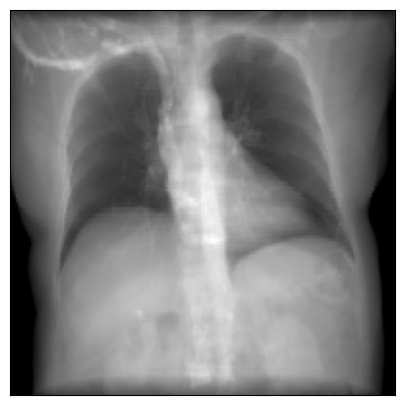

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d
from diffdrr.visualization import plot_drr

# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,  # A diffdrr.data.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
).to(device)

# Get parameters for the detector
alpha, beta, gamma = 0.0, 0.0, 0.0
bx, by, bz = 0.0, 850.0, 0.0
rotations = torch.tensor([[alpha, beta, gamma]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)

# MNake the DRR
target_drr = drr(
    rotations, translations, parameterization="euler_angles", convention="ZYX"
)
plot_drr(target_drr, ticks=False)
plt.show()

Next, we create a function that measures multiscale normalized cross-correlation (mNCC) between the `target` DRR and a `moving` DRR, simulated by some perturbation from the true parameters of the `target` DRR.

In [ ]:
metric = MultiscaleNormalizedCrossCorrelation2d([13, None], [0.5, 0.5])


def get_metric(alpha, beta, gamma, bx, by, bz):
    rotations = torch.tensor([[alpha, beta, gamma]]).to(device)
    translations = torch.tensor([[bx, by, bz]]).to(device)
    moving_drr = drr(
        rotations, translations, parameterization="euler_angles", convention="ZXY"
    )
    return metric(target_drr, moving_drr)

Finally, we can simulate hundreds of `moving` DRRs and measure their cross correlation with the `target`.
Plotting the cross correlation versus the perturbation from the true DRR parameters allows us to visualize
the loss landscape for the six pose parameters. From this visualization, we see that the loss landscape
is convex in this neighborhood (±15 mm and ±180 degrees).

βγ: 100%|█████████| 32/32 [00:13<00:00,  2.33it/s]


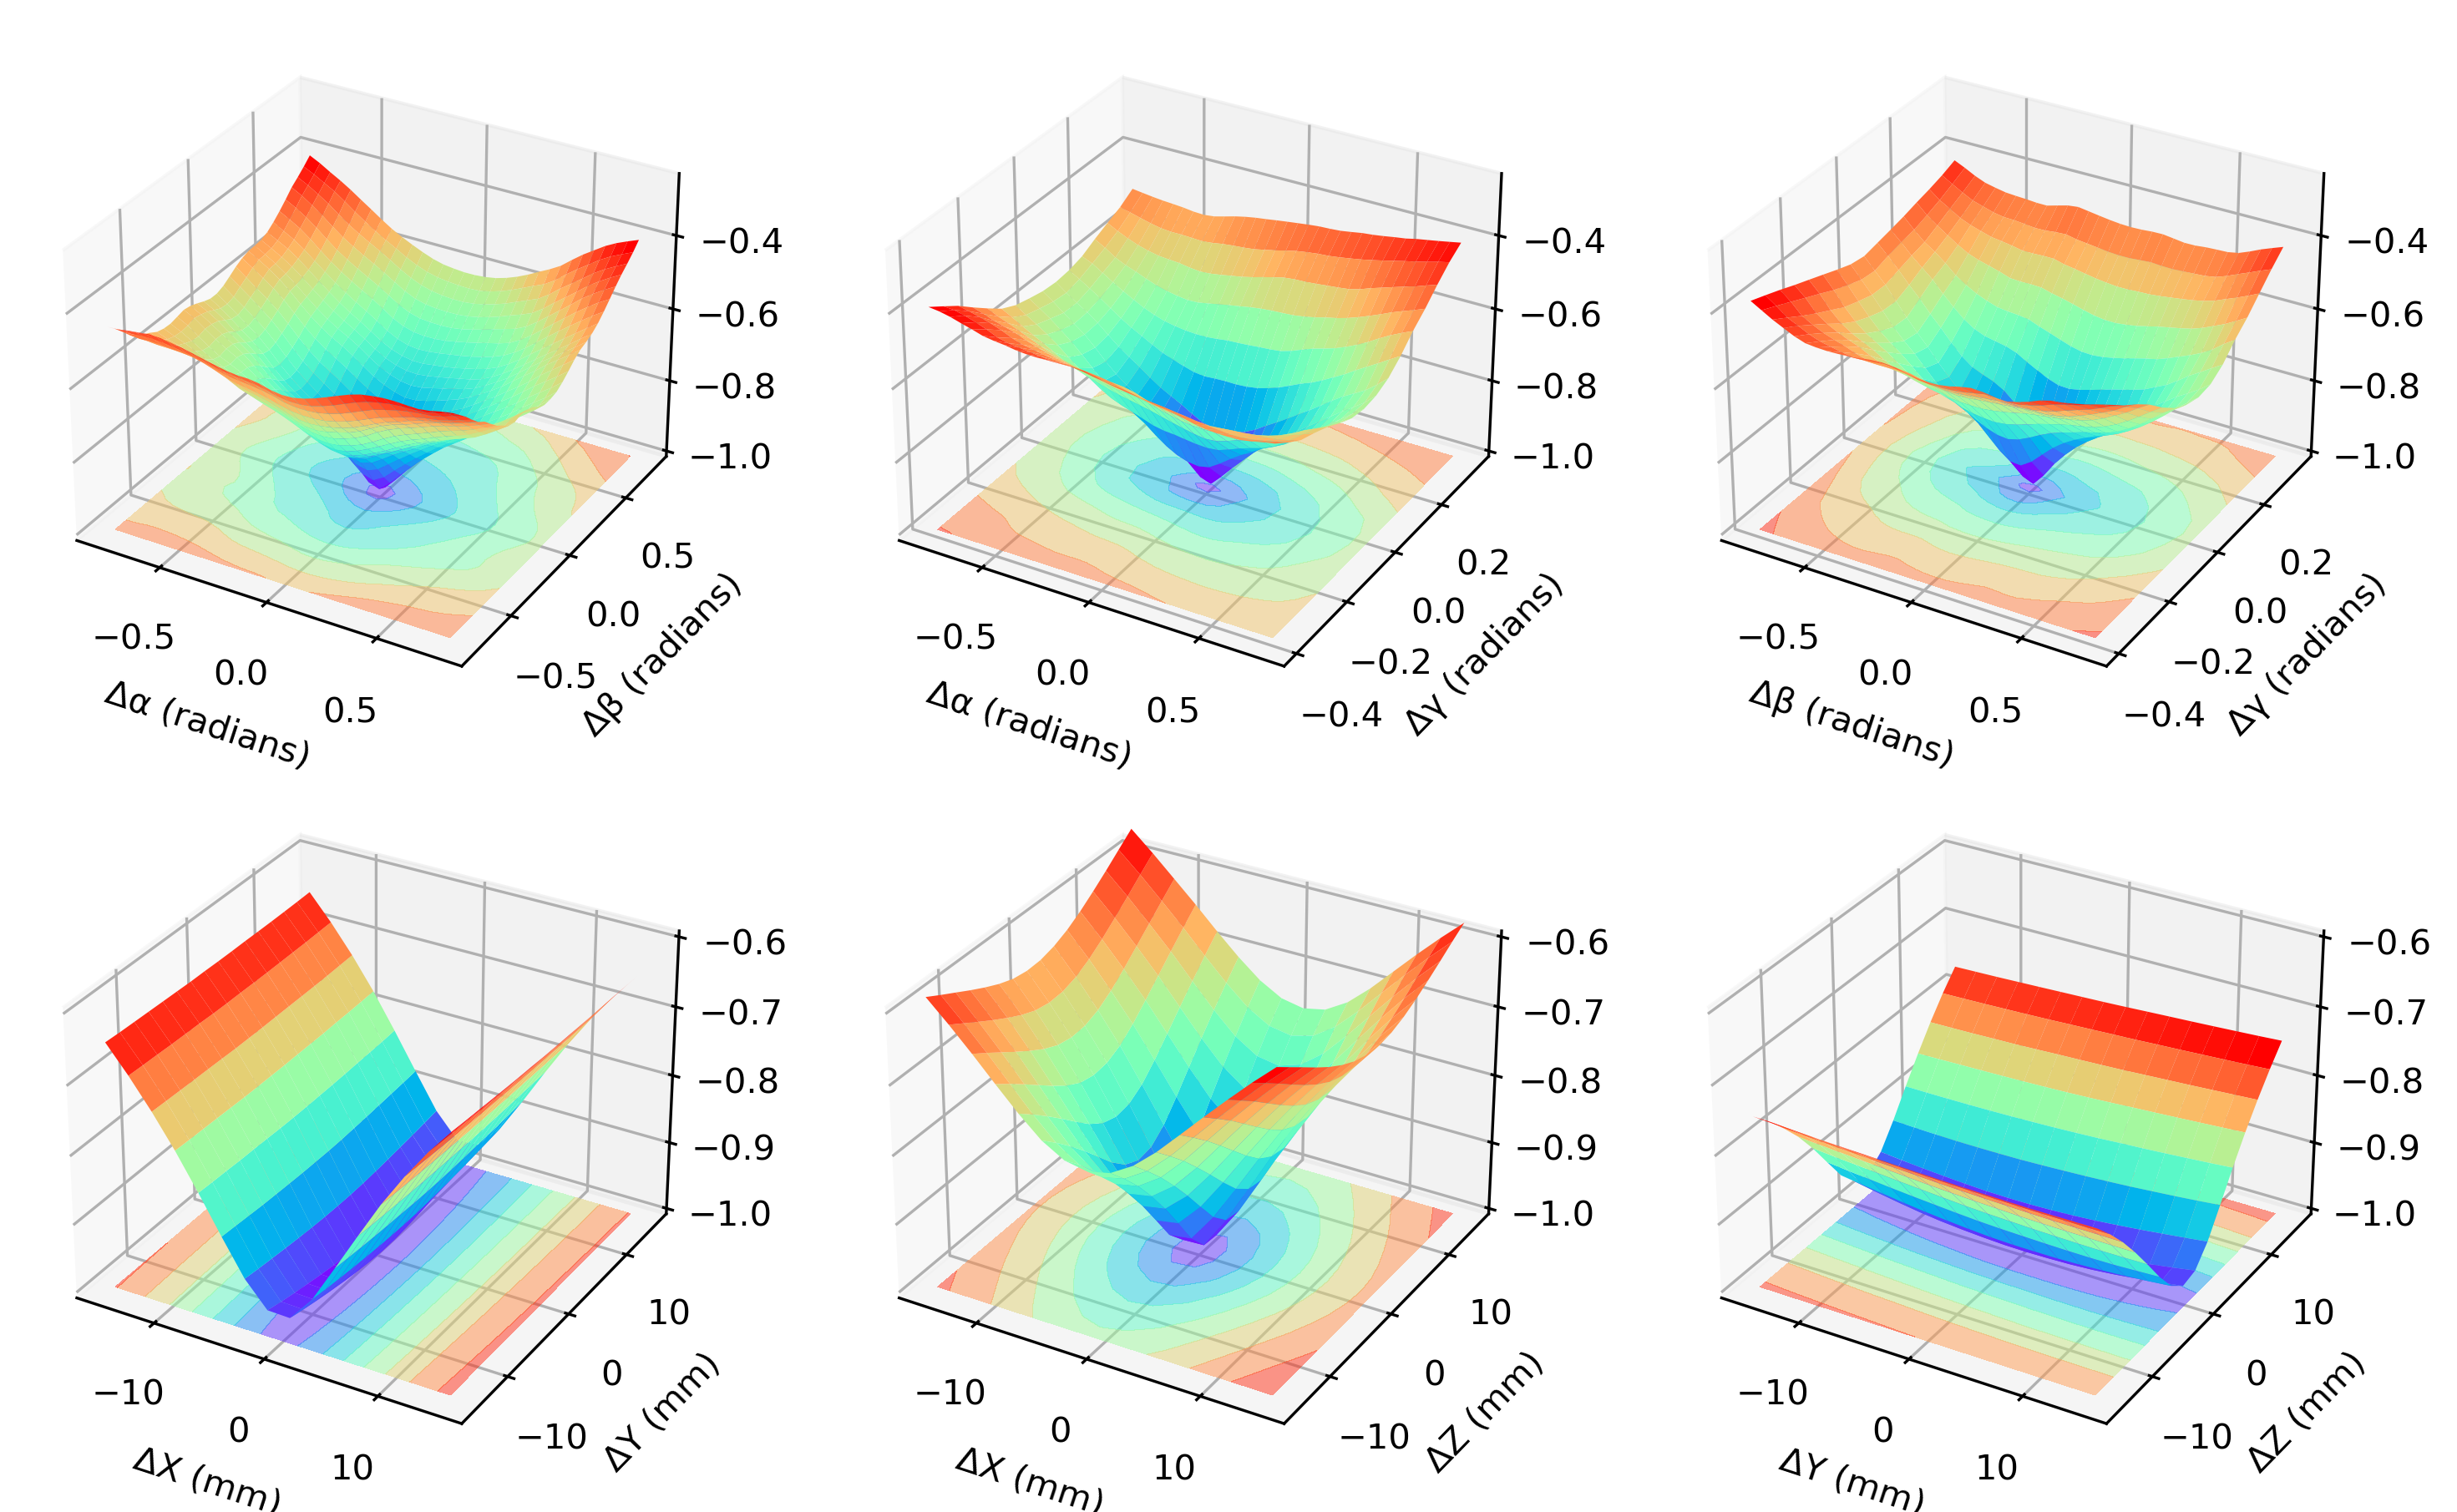

In [ ]:
#| code-fold: true
### NCC for the XYZs
xs = torch.arange(-15.0, 16.0, step=2)
ys = torch.arange(-15.0, 16.0, step=2)
zs = torch.arange(-15.0, 16.0, step=2)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs, desc="XY", ncols=50):
    for y in ys:
        xcorr = get_metric(alpha, beta, gamma, bx + x, by + y, bz)
        xy_corrs.append(-xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))

xz_corrs = []
for x in tqdm(xs, desc="XZ", ncols=50):
    for z in zs:
        xcorr = get_metric(alpha, beta, gamma, bx + x, by, bz + z)
        xz_corrs.append(-xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))

yz_corrs = []
for y in tqdm(ys, desc="YZ", ncols=50):
    for z in zs:
        xcorr = get_metric(alpha, beta, gamma, bx, by + y, bz + z)
        yz_corrs.append(-xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

### NCC for the angles
a_angles = torch.arange(-torch.pi / 4, torch.pi / 4, step=0.05)
b_angles = torch.arange(-torch.pi / 4, torch.pi / 4, step=0.05)
g_angles = torch.arange(-torch.pi / 8, torch.pi / 8, step=0.05)

# Get coordinate-wise correlations
tp_corrs = []
for t in tqdm(a_angles, desc="αβ", ncols=50):
    for p in b_angles:
        xcorr = get_metric(alpha + t, beta + p, gamma, bx, by, bz)
        tp_corrs.append(-xcorr)
TP = torch.tensor(tp_corrs).reshape(len(a_angles), len(b_angles))

tg_corrs = []
for t in tqdm(a_angles, desc="αγ", ncols=50):
    for g in g_angles:
        xcorr = get_metric(alpha + t, beta, gamma + g, bx, by, bz)
        tg_corrs.append(-xcorr)
TG = torch.tensor(tg_corrs).reshape(len(a_angles), len(g_angles))

pg_corrs = []
for p in tqdm(b_angles, desc="βγ", ncols=50):
    for g in g_angles:
        xcorr = get_metric(alpha, beta + p, gamma + g, bx, by, bz)
        pg_corrs.append(-xcorr)
PG = torch.tensor(pg_corrs).reshape(len(b_angles), len(g_angles))

### Make the plots

# XYZ
xyx, xyy = torch.meshgrid(xs, ys, indexing="ij")
xzx, xzz = torch.meshgrid(xs, zs, indexing="ij")
yzy, yzz = torch.meshgrid(ys, zs, indexing="ij")

fig = plt.figure(figsize=3 * plt.figaspect(1.2 / 1), dpi=300)

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔX (mm)")
ax.set_ylabel("ΔY (mm)")
ax.set_zlim3d(-1.0, -0.6)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔX (mm)")
ax.set_ylabel("ΔZ (mm)")
ax.set_zlim3d(-1.0, -0.6)

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔY (mm)")
ax.set_ylabel("ΔZ (mm)")
ax.set_zlim3d(-1.0, -0.6)

# Angles
xyx, xyy = torch.meshgrid(a_angles, b_angles, indexing="ij")
xzx, xzz = torch.meshgrid(a_angles, g_angles, indexing="ij")
yzy, yzz = torch.meshgrid(b_angles, g_angles, indexing="ij")

ax = fig.add_subplot(2, 3, 1, projection="3d")
ax.contourf(xyx, xyy, TP, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xyx, xyy, TP, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δα (radians)")
ax.set_ylabel("Δβ (radians)")
ax.set_zlim3d(-1.0, -0.25)

ax = fig.add_subplot(2, 3, 2, projection="3d")
ax.contourf(xzx, xzz, TG, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xzx, xzz, TG, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δα (radians)")
ax.set_ylabel("Δγ (radians)")
ax.set_zlim3d(-1.0, -0.25)

ax = fig.add_subplot(2, 3, 3, projection="3d")
ax.contourf(yzy, yzz, PG, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(yzy, yzz, PG, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δβ (radians)")
ax.set_ylabel("Δγ (radians)")
ax.set_zlim3d(-1.0, -0.25)

plt.show()

This plot shows that the only pose parameter for which there are relatively flat gradients is translation along the y-axis. In our coordinate system, this corresponds to the source-to-isocenter distance. That is, using mNCC, it may be difficult to disambiguate the camera's depth.